In [141]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from numpy import arange
import numpy as np

<ipython-input-146-cf28b8c591c3>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-146-cf28b8c591c3>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-146-cf28b8c591c3>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-146-cf28b8c591c3>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-146-cf28b8c591c3>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

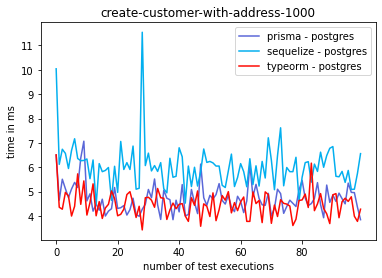

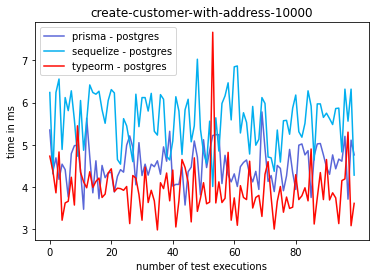

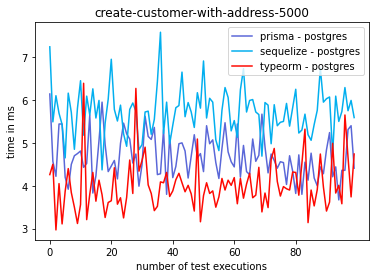

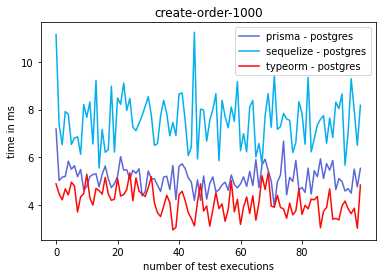

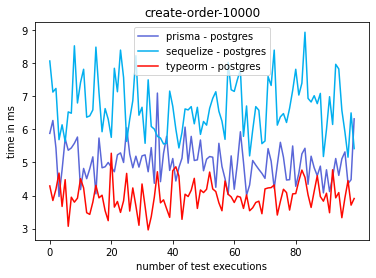

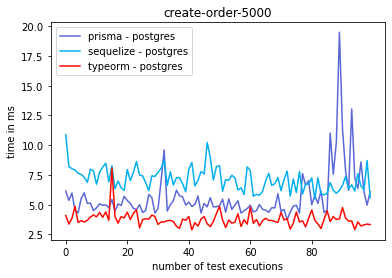

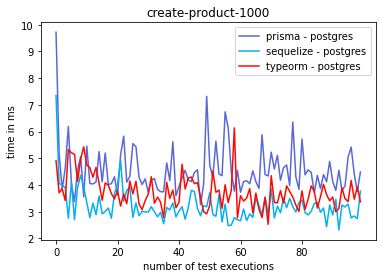

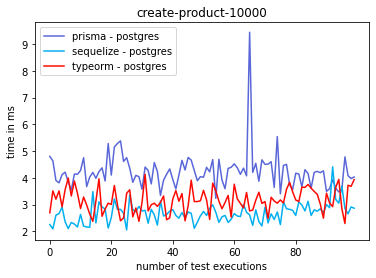

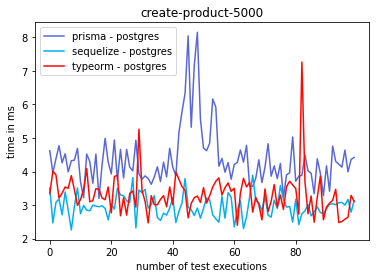

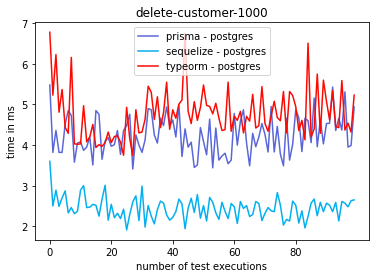

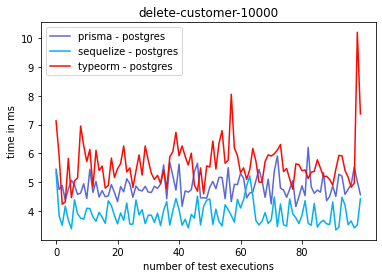

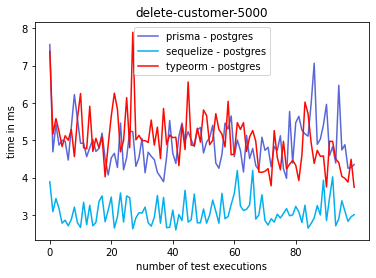

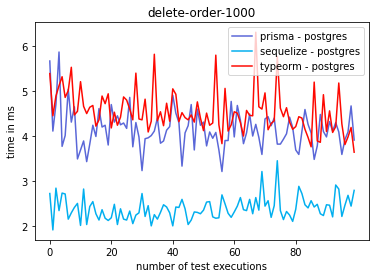

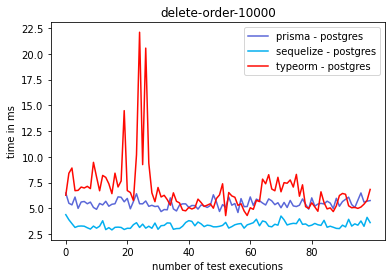

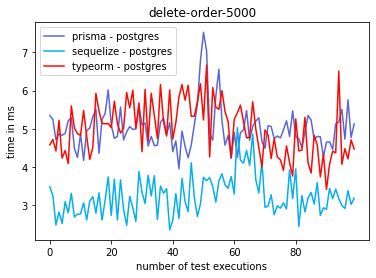

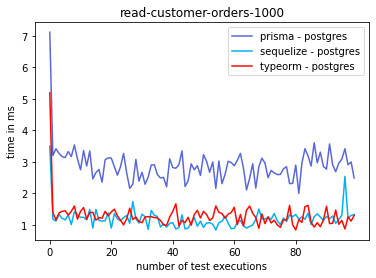

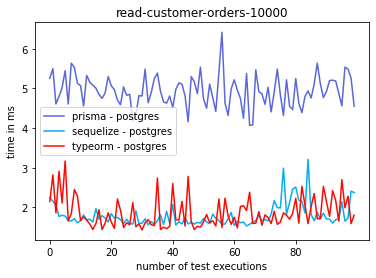

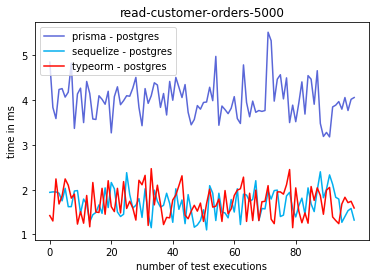

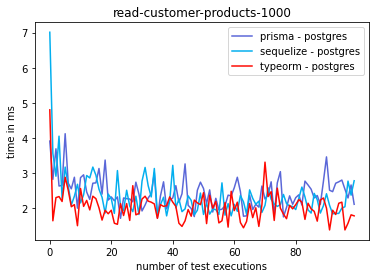

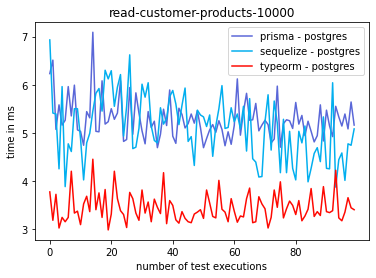

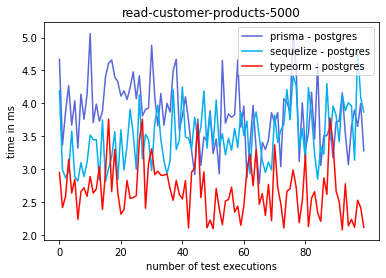

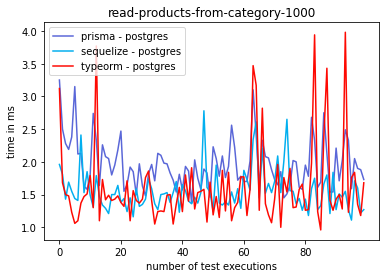

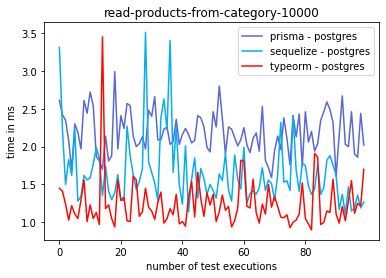

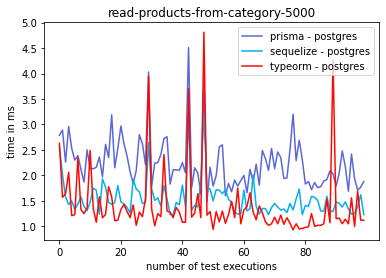

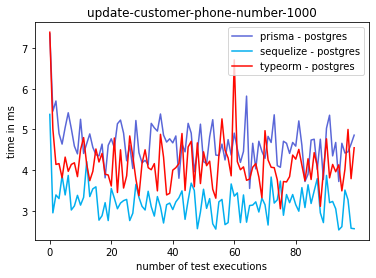

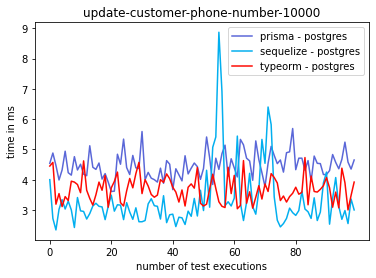

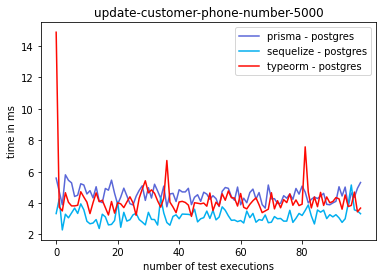

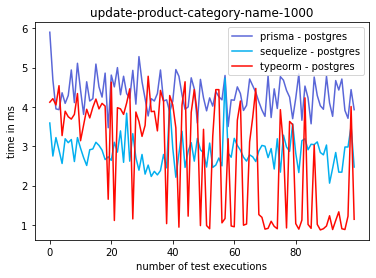

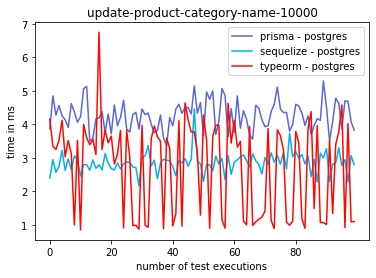

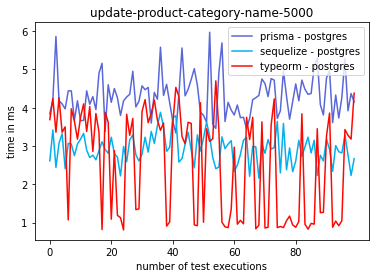

In [146]:
colorsMap = {
    "prisma": "#5A67D8",
    "typeorm": "#FE0902",
    "sequelize": "#02AFEF"
}


class CustomDataSet:
    dir = "" # e.g. C:\workspace\orm\orm-client\result\create\create-customer-with-address-100
    path = "" # e.g. C:\workspace\orm\orm-client\result\create\create-customer-with-address-100\prisma.postgres.2023-03-21T11-47-30.csv
    csv_file_name = "" # e.g. prisma.postgres.2023-03-21T11-47-30.csv
    framework = "" # prisma | typeorm | sequelize
    db = "" # postgres | mysql | mssql
    method = "" # create | read | update | delete
    test_name = "" # e.g. create-customer-with-address-100
    df = None
    describe = None
    describeDf = None
    color = None

    def __init__(self, path, method, test_name, csv_file_name):
        self.dir = os.path.dirname(path)
        self.path = path
        self.method = method
        self.test_name = test_name
        self.csv_file_name = csv_file_name
        self.framework = csv_file_name.split(".")[0]
        self.db = csv_file_name.split(".")[1]
        self.df = read_csv(path, sep=";")
        self.color = colorsMap[self.framework]
        

    def create_describe(self):
        # create describe for time column
        self.describe = self.df["time"].describe()
        # create csv with describe values
        self.describe.to_csv(self.dir + "/" + self.csv_file_name + ".describe.csv", float_format="%.2f")
        # convert describe indexes to columns and create new dataframe
        self.describeDf = pd.DataFrame([self.describe[self.describe.index.values]], columns=self.describe.index.values, index=[self.get_framework_db_string()])

    def get_framework_db_string(self):
        return self.framework + " - " + self.db

class CustomerConverter:
    datasets = []
    test_name_to_datasets = {}
    test_name_to_describe_groups = {}

    def convert(self, path):
        datasets = []
        for file_path in glob.iglob(path + "/**/*.csv", recursive=True):
            if (file_path.find("describe") != -1):
                continue
            [result_dir, method, test_name, csv_file_name] = file_path.split("\\")
            dataset = CustomDataSet(file_path,method,test_name,csv_file_name)
            self.datasets.append(dataset)
        self.create_describe()
        self.group_datasets()

    def create_describe(self):
        for dataset in self.datasets:
            dataset.create_describe()

    def group_datasets(self):
        for dataset in self.datasets:
            if dataset.test_name not in self.test_name_to_datasets:
                self.test_name_to_datasets[dataset.test_name] = []
            self.test_name_to_datasets[dataset.test_name].append(dataset)

    def create_describe_for_groups(self):
        for test_name, datasets in self.test_name_to_datasets.items():
            df = None
            for dataset in datasets:
                if df is None:
                    df = dataset.describeDf
                else:
                    df = df.append(dataset.describeDf)

            df.reset_index(inplace=True)
            df.rename(columns={'index': 'framework.db'}, inplace=True)
            df.reset_index()
            df.to_csv(datasets[0].dir +"/merged.describe.csv", float_format="%.2f")
            self.test_name_to_describe_groups[test_name] = df

    def create_charts(self):
        dfs = []
        for test_name, datasets in self.test_name_to_datasets.items():
            test_name_to_times = {}
            colors = []
            for dataset in datasets:
                test_name_to_times[dataset.get_framework_db_string()] = dataset.df["time"]
                colors.append(dataset.color)
            df = pd.DataFrame(test_name_to_times)
            dfs.append(df)
            df.plot(title=test_name, xticks=np.arange(min(df.index), max(df.index), 20), xlabel="number of test executions", ylabel="time in ms", color=colors)

converter = CustomerConverter()
converter.convert("C:/workspace/orm/orm-client/result")
converter.create_describe_for_groups()
converter.create_charts()